<a href="https://colab.research.google.com/github/clomia/AIB-Section1-Project/blob/master/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import Tuple
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

data = pd.read_csv('https://drive.google.com/uc?export=download&id=1wH6BUzfoXJx_yrOVNj7Ewt2lFJ5MGIPW')
origin_data = data.copy()

# Pre-processing

## 판매량 데이터 전처리

판매량을 환산하는 함수입니다.  
기본값으로 백만단위를 사용하며, 0으로 표기된것은  
단위에 미치지 못한 0이상의 숫자라고 간주하여 (단위/2)값으로 대체합니다  .
  
( 단위로는 K = 1_000 , M = 1000_000 , 기본 = 1000_000 입니다. )

In [2]:
def numericization(value):
    M = 1000_000
    K = 1_000

    def KM_product(number,unit):
        result = number * unit
        return result if result else unit/2

    logic_dict = {
        'K':lambda value: KM_product( float(value), K ),
        'M':lambda value: KM_product( float(value), M ),
    }
    try:
        result = KM_product( float(value), M )
    except ValueError:
        unit,number = value[-1],value[:-1]
        result = logic_dict[unit](number)
    return np.int64(result)

## 출시년도 데이터 전처리  

연도 데이터에서 잘못된 값과 결측치를 처리합니다. 
   
**잘못된 값 복구**  
잘못된 값은 연도 범위에서 벗어난 두자리 숫자입니다.  
데이터 분석 결과 잘못된 값은 무조건 20이하이거나 80이상입니다.  
또한 올바른 연도데이터가 가지는 범위는 (1980 ~ 2020) 입니다.  
즉, 잘못된 값이 20이하인 경우 2000을 더하고,  
80 이상인 경우 1900을 더해서 올바른 연도로 복구합니다. 
  
**결측치 처리**  
위에서 처리된 데이터의 평균,표준편차,분산을 모방하는  
샘플 데이터셋을 생성하여 결측치를 매꿉니다.  
결과적으로 데이터의 통계치 회손을 최소화합니다.

아래 코드는 간단하게 데이터를 확인하는 작업입니다.

In [3]:
normal_elements , denormal_elements = [] , []


class Filter:
    def __init__(self, normal:bool , container:list):
        self.normal = normal
        self.container = container
    
    def __call__(self,func):
        def wrapper(year):
            return_value = func(year)
            if not return_value:
                if not self.normal:
                    self.container.append(np.nan)
                return
            length,year = return_value
            if self.normal and length == 4:
                self.container.append(year)
            elif (not self.normal) and length != 4:
                self.container.append(year)
            return return_value
        return wrapper

    @staticmethod                
    def function(year):
        try:
            year = np.int64(year)
        except ValueError:
            return 
        else:
            return len(str(year)),year

        
@Filter(normal=True,container=normal_elements)
def normal_sampling(year):
    return Filter.function(year)

@Filter(normal=False,container=denormal_elements)
def denormal_sampling(year):
    return Filter.function(year)


data['Year'].apply(denormal_sampling)
data['Year'].apply(normal_sampling)


# "assertion failed"가 발생하지 않는것을 통해서 NAN이 아닌 비정상적인 년도는 모두 20이하이거나 80이상이라는것을 증명합니다.
filter_20_to_80 = tuple( value for value in denormal_elements if value <= 20 or value >= 80 )
filter_not_nan = tuple( value for value in denormal_elements if value is not np.nan )
assert filter_20_to_80 == filter_not_nan

round_int = lambda number:int(round(number,0))
data_info = {
    '평균':round_int(np.mean(normal_elements)),
    '분산':round_int(np.var(normal_elements)),
    '표준편차':round_int(np.std(normal_elements)),
}
# 평균:2006 , 표준편차:6

missing_values = tuple( object for value in denormal_elements if value is np.nan )
MISSING_VALUE_COUNT = len(missing_values)

print(f'올바른 연도값의 최대와 최소: {min(normal_elements)} , {max(normal_elements)}')
print(f'결측치 갯수:{MISSING_VALUE_COUNT}') # 결측치 갯수: 271개

올바른 연도값의 최대와 최소: 1980 , 2020
결측치 갯수:271


결측치를 매꾸기 위한 샘플 데이터를 생성합니다.  
**기존 데이터의 평균과 표준편차를 모방한 샘플 데이터**를 생성하고 올바른지 테스트합니다.

In [4]:
sampling = lambda : round_int(data_info['표준편차'] * np.random.randn() + data_info['평균'])
sample = [ sampling() for _ in range(MISSING_VALUE_COUNT) ]

print(f"기존 데이터-> 평균:{data_info['평균']} , 분산:{data_info['분산']} , 표준편차:{data_info['표준편차']}")
print(f"새롭게 샘플링된 데이터-> 평균:{round_int(np.mean(sample))} , 분산:{round_int(np.var(sample))} , 표준편차:{round_int(np.std(sample))}")

기존 데이터-> 평균:2006 , 분산:34 , 표준편차:6
새롭게 샘플링된 데이터-> 평균:2006 , 분산:33 , 표준편차:6


위에서 진행한 분석을 기반으로 연도 데이터를 처리하는 함수입니다.

In [5]:
def year_product(value):
    try:
        value = np.int64(value)
    except ValueError:
        value = sample.pop()
        return value if value < 2021 else 2020
    else:
        if 1980 <= value <= 2020:
            return value
        return value + ( 2000 if value <= 20 else 1900 )

## 판매량과 출시년도에 데이터 처리 적용

In [6]:
target = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
data[target] = data[target].applymap(numericization) # 판매 데이터 처리
data['Total_Sales'] = data['NA_Sales'] + data['EU_Sales'] + data['JP_Sales'] + data['Other_Sales']	
data.index = data['Year'].apply(year_product) # 출시년도 데이터 처리
data = data.drop(['Unnamed: 0','Year'],axis=1).sort_index(ascending=False) 
data.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Year,,,,,,,,,
2020,Imagine: Makeup Artist,DS,Simulation,Ubisoft,270000,500,500000,20000,790500
2019,Prinny: Can I Really Be The Hero? (US sales),PSP,Action,NaN,60000,500000,500000,500000,1560000
2019,Wet,X360,Shooter,Bethesda Softworks,230000,210000,10000,50000,500000
2018,The Golden Compass,Wii,Action,Sega,260000,280000,500000,70000,1110000
2018,Valkyria Chronicles III: Unrecorded Chronicles,PSP,Strategy,Sega,500000,500000,210000,500000,1710000


## Genre와 Publisher의 NaN값 대체  
Genre : "Misc"  
Publisher : "Unknown"

In [7]:
genre_missing_data = data['Genre'][ data['Genre'].isin([np.nan]) ]
publisher_missing_data = data['Publisher'][ data['Publisher'].isin([np.nan]) ]

data['Genre'] = data['Genre'].fillna('Misc')
data['Publisher'] = data['Publisher'].fillna('Unknown')

print(f'처리한 NaN 갯수| Genre:{len(genre_missing_data)} , Publisher:{len(publisher_missing_data)}')
data.info()

처리한 NaN 갯수| Genre:50 , Publisher:58
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 2020 to 1980
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16598 non-null  object
 1   Platform     16598 non-null  object
 2   Genre        16598 non-null  object
 3   Publisher    16598 non-null  object
 4   NA_Sales     16598 non-null  int64 
 5   EU_Sales     16598 non-null  int64 
 6   JP_Sales     16598 non-null  int64 
 7   Other_Sales  16598 non-null  int64 
 8   Total_Sales  16598 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.3+ MB


# 필수 내용

In [8]:
# Constant 정의
extract = lambda name: tuple(set(data[name].values))

GENRES,PLATFORMS,PUBLISHER = extract('Genre') , extract('Platform') , extract('Publisher')
REGIONS = ('NA_Sales','EU_Sales','JP_Sales')
YEARS = tuple(range(1980,2021))

## 지역에 따라서 선호하는 게임 장르가 다를까  
North America, European Union, Japan  
  
[PlatForm은 비디오 게임 및 액션 장르의 하위장르이다.](https://en.wikipedia.org/wiki/Platform_game)

In [9]:
def visualization(region):
    sns.barplot(x=region, y="Genre", data=data)
    plt.title(f"{region} Data")

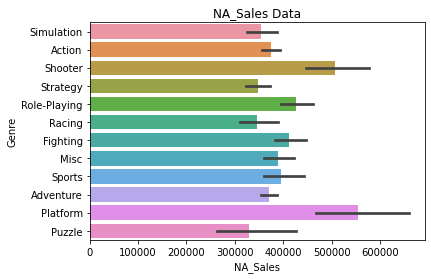

In [10]:
visualization("NA_Sales") # Top: Platform

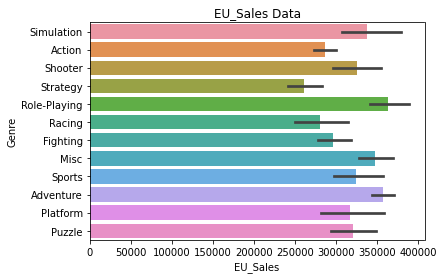

In [11]:
visualization("EU_Sales") # Top: Role-Playing

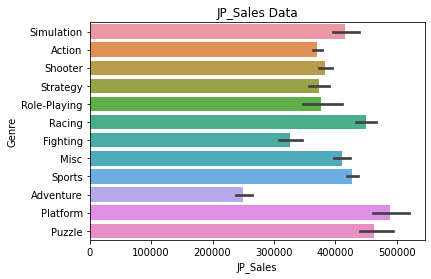

In [12]:
visualization("JP_Sales") # Top: Platform

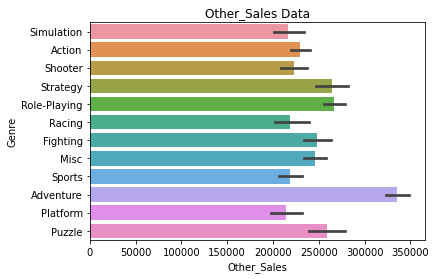

In [13]:
visualization("Other_Sales") # Top: Adventure

장르별로 ANOVA 분석

In [14]:
anova_result = []
for genre in GENRES:
    oper_df = data[ data['Genre'] == genre ]
    groups = [ oper_df[region] for region in REGIONS ]
    _,p_value = stats.f_oneway(*groups)
    if p_value < 0.05:
        print(f"지역에 따라서 {genre}장르의 선호도는 유의미한 차이를 보입니다.")	
        anova_result.append(genre)
result = f"지역에 따라서 선호하는 게임 장르가 {'다릅'if tuple(anova_result)==GENRES else'다르지 않습'}니다."
print(result)

지역에 따라서 Puzzle장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Simulation장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Strategy장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Racing장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Platform장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Shooter장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Misc장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Role-Playing장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Fighting장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Sports장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Action장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Adventure장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 선호하는 게임 장르가 다릅니다.


## 연도별 게임의 트렌드가 있을까

### TrendAnalysis Object

In [15]:
import os
from concurrent.futures import ProcessPoolExecutor

class TrendAnalysis:
    """ 
    주어진 DataFrame를 Genre,Platform,Publisher 피처들로 나눈 뒤
    각 피처별로 피처를 구성하는 카테고리 별 판매 비율을 연도별로 산출한다.

    -- 결과 데이터 접근 API--
    TA = TrendAnalysis(df)
    TA.info.genre
    TA.info.platform
    TA.info.publisher

    -- 결과 시각화 API --
    TA()
    """

    genre = "genre"
    platform = "platform"
    publisher = "publisher"
    
    def __init__(self,data:pd.DataFrame,multiprocessing=True):
        self.data = data
        self.info = self._multiprocessing() if multiprocessing else self._processing()
    
    def lineplot(self,attr:str,y:str):
        """ x축이 연도인 line plot을 그립니다. """
        df = self.info.__dict__[attr]
        sns.lineplot(x=df.index,y=y,data=df)
        plt.title(y.capitalize())
        plt.ylim(0, 100)
 
    def _percentification(self,column,year):
        """ 
        data에서 column의 종류별 판매 비율을 연도별로 산출한다.
        """ 
        result = {}
        total = self.data.loc[year]['Total_Sales'].sum()
        for kind in extract(column):
            try:
                target_data = self.data[ self.data[column] == kind ].loc[year]
            except KeyError:
                result[kind] = 0
            else:    
                result[kind] = ( target_data['Total_Sales'].sum()/total )*100
        return result

    def _processing(self):
        property_data = {
            self.genre : pd.DataFrame(index=YEARS,columns=GENRES),
            self.platform : pd.DataFrame(index=YEARS,columns=PLATFORMS),
            self.publisher : pd.DataFrame(index=YEARS,columns=PUBLISHER),
        }

        for year in YEARS:
            property_data[self.genre].loc[year] = self._percentification('Genre',year)
            property_data[self.platform].loc[year] = self._percentification('Platform',year)
            property_data[self.publisher].loc[year] = self._percentification('Publisher',year)
        
        result = { key:value.astype(float) for key,value in property_data.items() }
        return type('Info',(),result)

    def _operation(self,args):
        target,columns = args
        df = pd.DataFrame(index=YEARS,columns=columns)
        for year in YEARS:
            df.loc[year] = self._percentification(target.capitalize(),year)
        return target,df

    def _multiprocessing(self):   
        property_data = {}
        pool = ProcessPoolExecutor(max_workers=os.cpu_count())
        args = (
            (self.genre,GENRES),
            (self.platform,PLATFORMS),
            (self.publisher,PUBLISHER),
        )
        operator = pool.map(self._operation,args)
        for result in operator:
            target,df = result
            property_data[target] = df.astype(float)

        return type('Info',(),property_data)

In [16]:
analysis_result = TrendAnalysis(data)

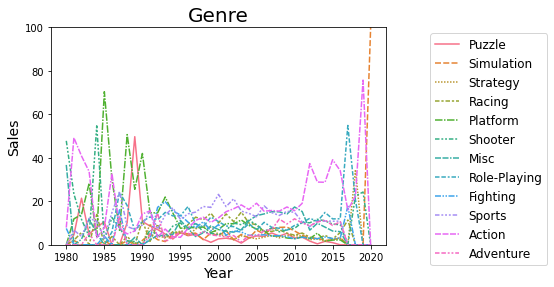

<Figure size 1440x1440 with 0 Axes>

In [56]:
df = analysis_result.info.genre

ax = sns.lineplot(data=df)
plt.title('Genre', fontsize=20)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylim(0, 100)
plt.legend(fontsize=12,bbox_to_anchor=(1.5, 1))
plt.figure(figsize=(20,20))
plt.savefig('./.png')
#plt.show()

### 연도별 점유율

#### 장르  
총 11개 (기타 제외)    
Puzzle, Simulation, Strategy, Racing, Platform, Shooter, Role-Playing, Fighting, Sports, Action, Adventure

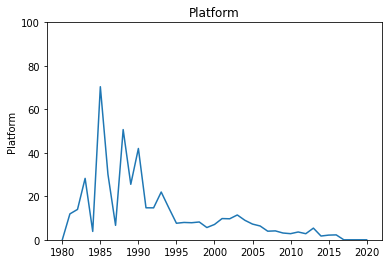

In [35]:
analysis_result.lineplot(TrendAnalysis.genre,"Platform") # 플랫폼

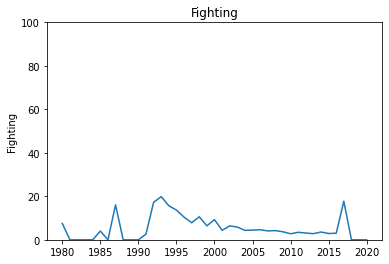

In [36]:
analysis_result.lineplot(TrendAnalysis.genre,"Fighting") # 격투

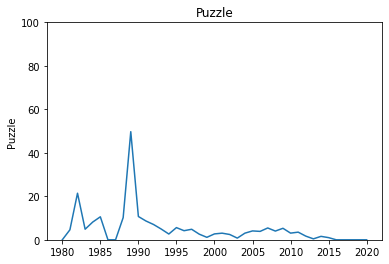

In [37]:
analysis_result.lineplot(TrendAnalysis.genre,"Puzzle") # 퍼즐

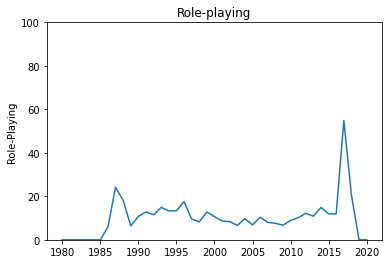

In [38]:
analysis_result.lineplot(TrendAnalysis.genre,"Role-Playing") # 롤플레잉

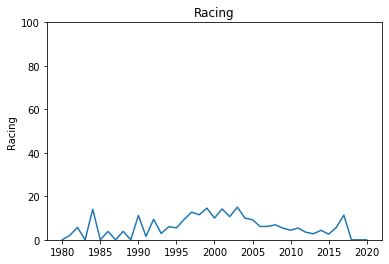

In [39]:
analysis_result.lineplot(TrendAnalysis.genre,"Racing") # 레이싱

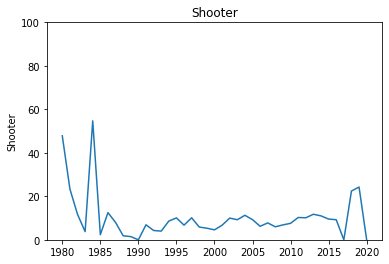

In [40]:
analysis_result.lineplot(TrendAnalysis.genre,"Shooter") # 슈팅

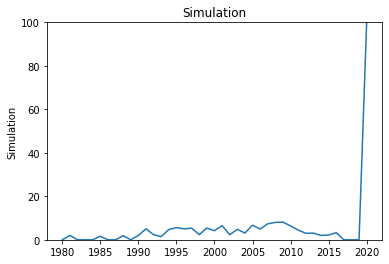

In [41]:
analysis_result.lineplot(TrendAnalysis.genre,"Simulation") # 시뮬레이션

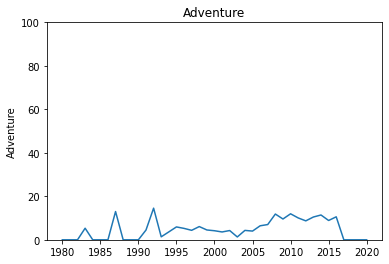

In [42]:
analysis_result.lineplot(TrendAnalysis.genre,"Adventure") # 어드벤처

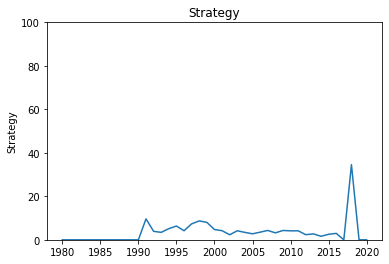

In [43]:
analysis_result.lineplot(TrendAnalysis.genre,"Strategy") # 전략

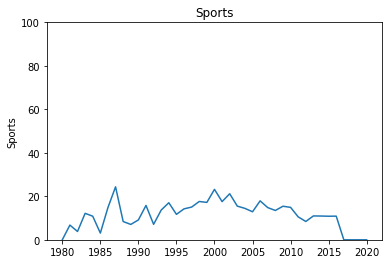

In [44]:
analysis_result.lineplot(TrendAnalysis.genre,"Sports") # 스포츠

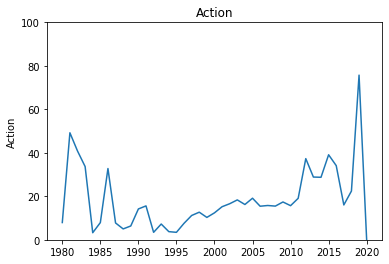

In [45]:
analysis_result.lineplot(TrendAnalysis.genre,"Action") # 액션

#### 플랫폼

In [33]:
#analysis_result.lineplot(TrendAnalysis.platform,"Platform") 
len(PLATFORMS)

31

## 출고량이 높은 게임에 대한 분석 및 시각화 프로세스